リアルタイム異常検知を想定し、データ範囲をスライドさせながら最後のデータの異常検知を実行。

連続して10回以上正常が続いた後に異常が検出された場合にのみ、その部分のデータを赤色でプロット。

以降の範囲では緑色でプロット

n=10

          0
0  0.390000
1  0.910761
2  0.311148
3  0.820547
4  0.563721
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       2001 non-null   float64
dtypes: float64(1)
memory usage: 15.8 KB
None
                 0
count  2001.000000
mean      0.583615
std       0.300984
min       0.157245
25%       0.255411
50%       0.534727
75%       0.928117
max       0.957084


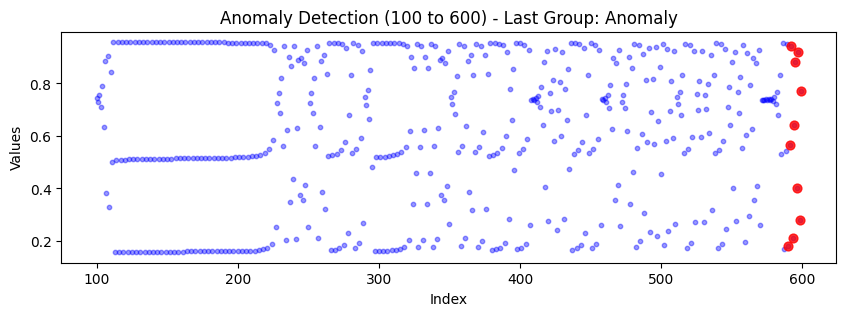

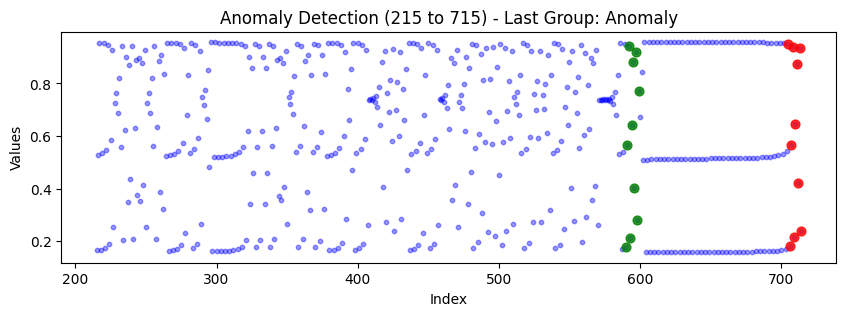

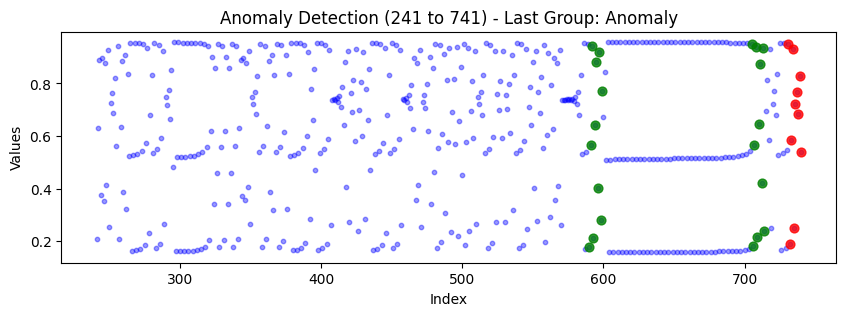

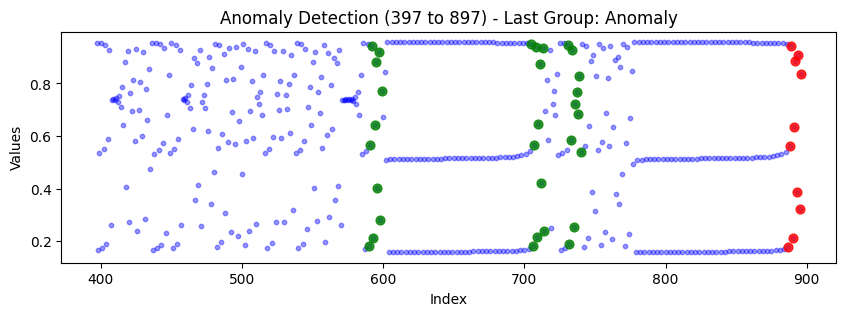

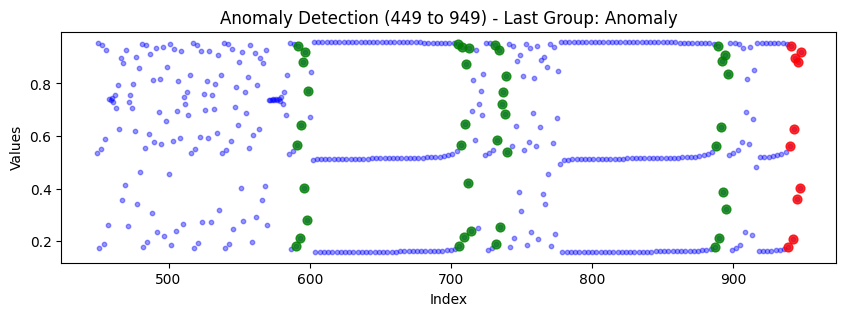

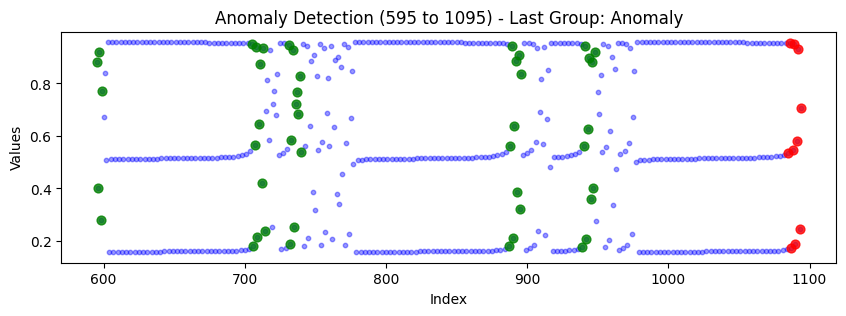

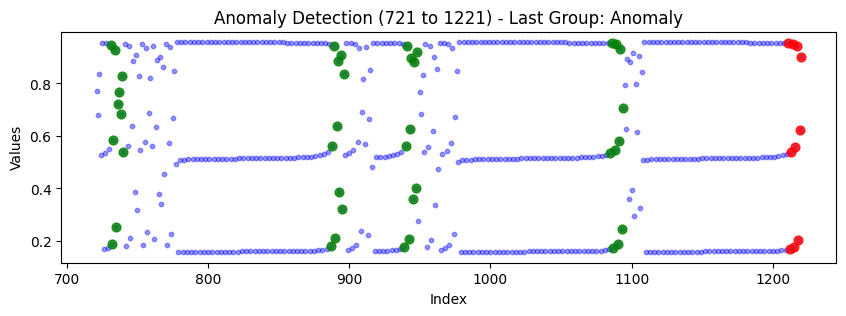

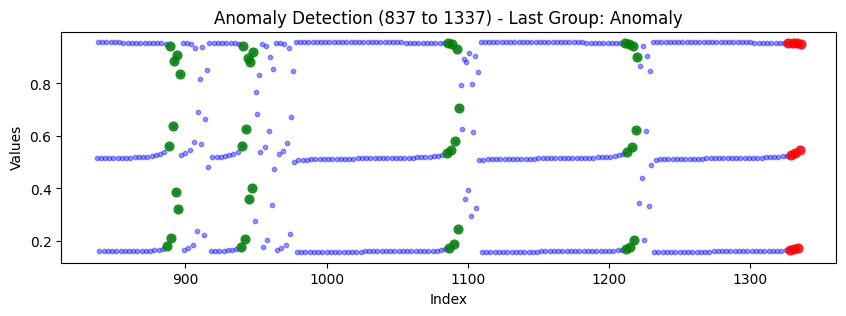

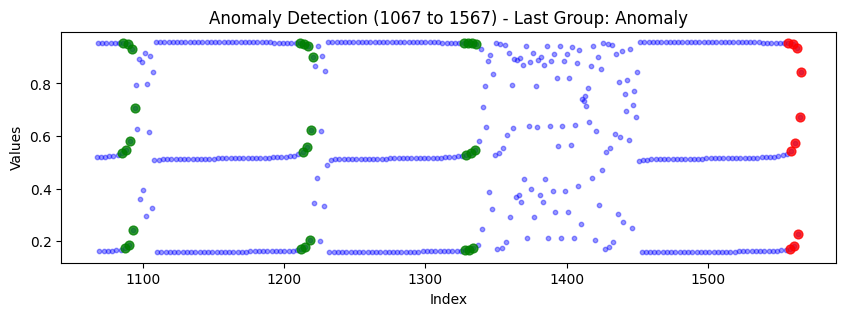

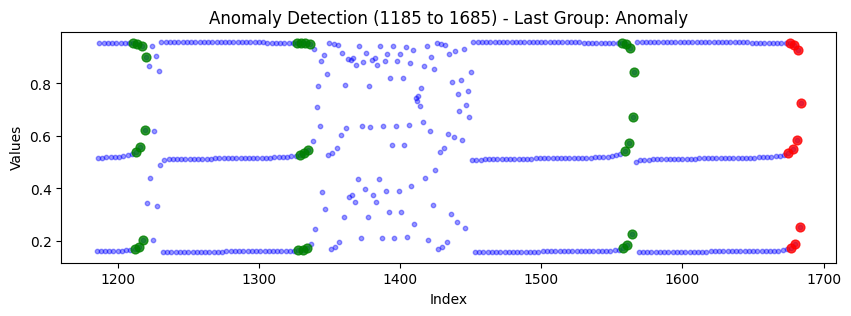

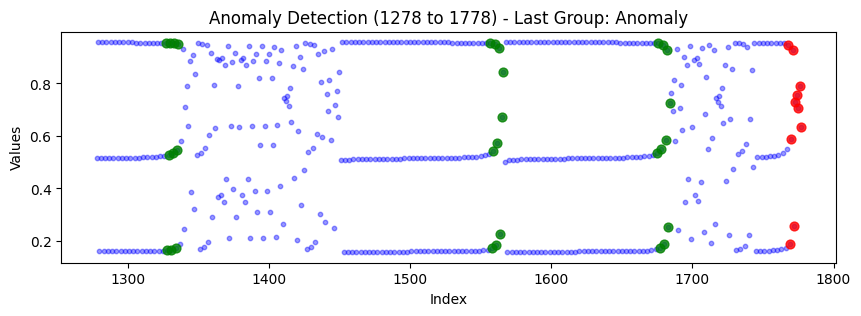

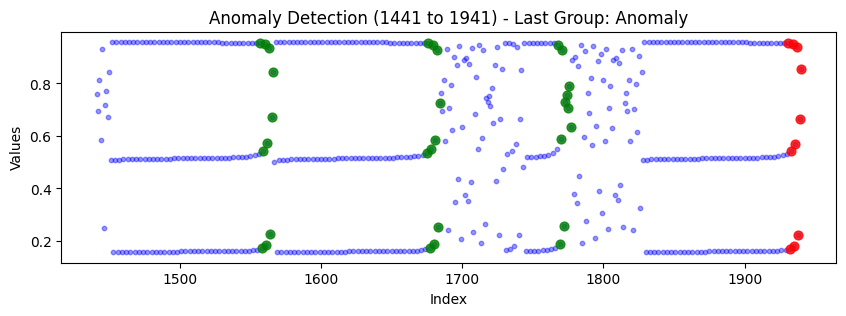

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# データの読み込み
data = pd.read_csv('data_3.csv')

# データの確認
print(data.head())
print(data.info())

# データの統計量を確認
print(data.describe())

# 連続するn個の点をn次元ベクトルとしてデータを再構築
def create_n_dim_vectors(data, window_size):
    vectors = []
    for i in range(len(data) - window_size + 1):
        vectors.append(data[i:i + window_size])
    return np.array(vectors)

# 異常検知とプロットを行う関数
def detect_and_plot_anomalies(data, window_size=500, n=10):
    normal_count = 0
    all_anomalies = set()
    newly_detected_anomalies = set()

    # 最後の範囲までスライドさせながら処理を行う
    for start in range(len(data) - window_size + 1):
        end = start + window_size
        one_dimensional_data = data[start:end]

        # n次元ベクトルのデータを作成
        n_dimensional_data = create_n_dim_vectors(one_dimensional_data, n)

        # DataFrameに変換
        columns = [f'X{i+1}' for i in range(n)]
        n_dimensional_df = pd.DataFrame(n_dimensional_data, columns=columns)

        # Isolation Forestの実装
        # Isolation Forestモデルの定義
        model = IsolationForest(contamination=0.3, random_state=4)  # contaminationは異常値の割合, random_stateは乱数のシード

        # モデルのフィッティング
        model.fit(n_dimensional_df)

        # 異常値の予測
        n_dimensional_df['anomaly'] = model.predict(n_dimensional_df)

        # 異常値は-1、正常値は1
        n_dimensional_df['anomaly'] = n_dimensional_df['anomaly'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')

        # 最後の組みの異常検知結果を取得
        last_group_anomaly = n_dimensional_df['anomaly'].iloc[-1]

        # 異常点だった場合のみプロット
        if last_group_anomaly == 'Anomaly':
            if normal_count >= 10:  # 連続して10回以上正常だった場合
                plt.figure(figsize=(10, 3))

                # 全ての点を青でプロット
                plt.scatter(range(start, end), one_dimensional_data, c='blue', alpha=0.4, s=10)

                # 最後の組みの点を赤でプロット
                anomalies_indices = range(end - n, end)
                newly_detected_anomalies.update(anomalies_indices)
                all_anomalies.update(newly_detected_anomalies)

                for i in range(start, end):
                    if i in all_anomalies:
                        color = 'green'
                        size = 40  # 異常点のサイズを大きく
                        alpha = 0.8  # 異常点の透明度を高く
                        if i in newly_detected_anomalies:
                            color = 'red'
                        plt.scatter(i, data[i], c=color, alpha=alpha, s=size)

                plt.xlabel('Index')
                plt.ylabel('Values')
                plt.title(f'Anomaly Detection ({start} to {end}) - Last Group: {last_group_anomaly}')
                plt.show()
                newly_detected_anomalies.clear()
            normal_count = 0  # リセット
        else:
            normal_count += 1  # 正常カウントを増やす

# データの範囲をスライドさせながら異常検知とプロットを実行
detect_and_plot_anomalies(data.iloc[:, 0].values)
